# With Dec=5e-10, Dcross=1e-14, Xi=-1.4; t_0+=0.28, Nyman008, run 1C cycling for 500 times and see what happen

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;
from scipy.io import savemat,loadmat;from pybamm import constants,exp,tanh,sqrt;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False
import traceback
import imageio.v2 as imageio
font = {'family' : 'Times New Roman',
        #'weight' : 'bold',
        'size'   : fs}
mpl.rc('font', **font)

In [2]:
# control parameter
D_ec_sei = 1e-19;

In [3]:
V_max = 4.2;        V_min = 2.5;
total_cycle = 30; save_at_cycles= 1
Experiment_Long   = pybamm.Experiment( [ (
    f"Discharge at 1 C until {V_min} V", 
    f"Charge at 1 C until {V_max} V", 
    f"Hold at {V_max} V until C/5")    ] * total_cycle ) 
Experiment_s   = pybamm.Experiment( [ (
    f"Discharge at 1 C for 240 s", )    ] * 1 )   

In [4]:
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R5/'; 
Target  = 'a1_scan_Dsol/'
if not os.path.exists(BasicPath + Target):
    os.mkdir(BasicPath + Target);

In [5]:
Model_d = pybamm.lithium_ion.DFN(     
    options={
        "SEI":"solvent-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",     
        "solvent diffusion": "EC wo refill"     } )
Model_dre = pybamm.lithium_ion.DFN(     
    options={
        "SEI":"solvent-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",     
        "solvent diffusion": "EC w refill"     } )
Model_s = pybamm.lithium_ion.DFN(     
    options={
        "SEI":"solvent-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",     
        "solvent diffusion": "none"     } )


Confirm: using solvent-diffusion limited
using EC wo refill for Li+
Confirm: using solvent-diffusion limited
using EC w refill for Li+
Confirm: using solvent-diffusion limited


Para_0.search('mole')

In [6]:
Models = [Model_s,Model_d,Model_dre]
ChemistryChen=pybamm.parameter_sets.Chen2020 
ChemistryChen["electrolyte"] = "lipf6_Valoen2005";
Para_0=pybamm.ParameterValues(chemistry=ChemistryChen);
Para_0['EC transference number'] =     -1.4
Para_0['Cation transference number'] =     0.28
Para_0['EC Lithium ion cross diffusivity [m2.s-1]'] = 1e-14
Para_0['Typical EC Lithium ion cross diffusivity [m2.s-1]'] =  1e-14
Para_0['EC diffusivity in electrolyte [m2.s-1]'] =  5e-10
Para_0['EC diffusivity in SEI [m2.s-1]'] =  D_ec_sei
#print(Model_d.options["solvent diffusion"])
Para_0['Ratio of lithium moles to SEI moles'] =  1
for model in Models:
    c_e = model.variables["Electrolyte concentration [mol.m-3]"]
    T = model.variables["Cell temperature [K]"]
    c_EC = model.variables["EC concentration [mol.m-3]"]
    model.variables["c(EC) over c(Li+)"] = c_EC / c_e
    model.variables["Electrolyte conductivity [S.m-1]"] =(
        Para_0['Electrolyte conductivity [S.m-1]'](c_e,c_EC, T))
    model.variables["Electrolyte diffusivity [m2.s-1]"] =(
        Para_0['Electrolyte diffusivity [m2.s-1]'](c_e,c_EC, T))

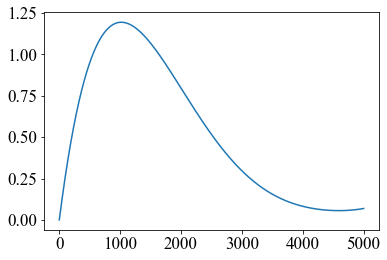

<AxesSubplot:>

In [33]:
c_e_plt = pybamm.linspace(0, 5e3, 1000)
sigma_plt = Para_0['Electrolyte conductivity [S.m-1]']
diff_plt  = Para_0['Electrolyte diffusivity [m2.s-1]']
pybamm.plot(c_e_plt, sigma_plt(c_e_plt,4540, 298.15))

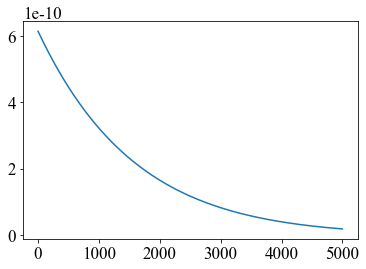

<AxesSubplot:>

In [34]:
pybamm.plot(c_e_plt, diff_plt(c_e_plt,4540, 298.15))

Xi =  list(np.linspace(-1.8, -1.0, 10))
print(type(Xi))

In [7]:
Sim = [];Sol=[]; 
for model in Models:
    var = pybamm.standard_spatial_vars  
    mesh_thick = 30; mesh_par=50;
    var_pts = {
        var.x_n: int(mesh_thick),  
        var.x_s: int(20),  
        var.x_p: int(mesh_thick),  
        var.r_n: int(mesh_par),  
        var.r_p: int(mesh_par),  }  
    sim = pybamm.Simulation(
        model, experiment = Experiment_Long,
        parameter_values = Para_0,
        solver = pybamm.CasadiSolver(),
        var_pts=var_pts,)  
    try:
        sol = sim.solve(save_at_cycles=save_at_cycles,);
        print(sol.cycles[-1].steps[-1]);  # a way to check whether the solution is finalized 
    except:
        print('Fail for model option: ',model.options["solvent diffusion"])
    else:
        Sol.append(sol)   
        print('Succeed for model option: ',model.options["solvent diffusion"])

Succeed for model option:  none
Succeed for model option:  EC wo refill
Succeed for model option:  EC w refill


In [8]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2_Crack_simp import (
    GetScan,
    recursive_scan,
    GetSol_dict,
    Para_init,
    Run_model_wwo_dry_out ,
    Cal_new_con_Update,
    Run_Model_Base_On_Last_Solution,
    Run_Model_Base_On_Last_Solution_RPT,
    write_excel_xlsx,
    Get_initial_cap,
    Get_initial_cap2
)

In [10]:
# post-processing - define dictionary
########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",

    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",

    "CDend EC concentration [mol.m-3]",
    "CDend Electrolyte concentration [mol.m-3]",

    "CDend EC flux [mol.m-2.s-1]",
    "CDend EC flux by diffusion [mol.m-2.s-1]",
    "CDend EC flux by migration [mol.m-2.s-1]",
    "CDend EC flux by Li+ [mol.m-2.s-1]",
    "CDend Li+ flux [mol.m-2.s-1]",
    "CDend Li+ flux by diffusion [mol.m-2.s-1]",
    "CDend Li+ flux by migration [mol.m-2.s-1]",
    "CDend Li+ flux by solvent [mol.m-2.s-1]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Total lithium in electrolyte [mol]",
    "CDend Total EC in electrolyte [mol]",
    "CDend Total EC in electrolyte and SEI [mol]",
]
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];

In [11]:
cycle_no_long = np.arange(0,total_cycle,save_at_cycles);
#cycle_no_long[0] = 0;
print(cycle_no_long);
print(cycle_no_long[0:-3])


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]


In [12]:
sol_s = Sol[0]; cycle_no_s = cycle_no_long
step_CD = 0;step_CC=1;step_CV = 2;
my_dict_s = {}; 
for keys in keys_all_RPT:
    for key in keys:
        my_dict_s[key]=[];
for cycle_i in cycle_no_s:
    my_dict_s_old = my_dict_s; del my_dict_s
    my_dict_s = GetSol_dict (my_dict_s_old,keys_all_RPT, sol_s, 
        cycle_i, step_CD , step_CC , -1, step_CV   )


In [13]:
sol_d = Sol[1]; cycle_no_d = cycle_no_long
my_dict_d = {}; 
for keys in keys_all_RPT:
    for key in keys:
        my_dict_d[key]=[];
for cycle_i in cycle_no_d:
    my_dict_d_old = my_dict_d; del my_dict_d
    my_dict_d = GetSol_dict (my_dict_d_old,keys_all_RPT, sol_d, 
        cycle_i, step_CD , step_CC , -1, step_CV   )


In [14]:
sol_dre = Sol[2]; cycle_no_dre =  cycle_no_long
my_dict_dre = {}; 
for keys in keys_all_RPT:
    for key in keys:
        my_dict_dre[key]=[];
for cycle_i in cycle_no_dre:
    my_dict_dre_old = my_dict_dre; del my_dict_dre
    my_dict_dre = GetSol_dict (
        my_dict_dre_old,keys_all_RPT, sol_dre , 
        cycle_i, step_CD , step_CC , -1, step_CV   )   


In [15]:
my_dict_all = [my_dict_s,my_dict_d,my_dict_dre]
cycle_no_all = [cycle_no_s,cycle_no_d,cycle_no_dre]

In [ ]:
# post-prosessing only when all are successful 
step_CD = 0;step_CC=1;step_CV = 2;
cycle_no = np.arange(-1,total_cycle,save_at_cycles);
cycle_no[0] = 0;
my_dict_all = []
print(cycle_no)
for sol in Sol:
    my_dict = {}; 
    for keys in keys_all_RPT:
        for key in keys:
            my_dict[key]=[];
    for cycle_i in cycle_no:
        my_dict_old = my_dict; del my_dict
        my_dict = GetSol_dict (my_dict_old,keys_all_RPT, sol, 
            cycle_i, step_CD , step_CC , -1, step_CV   )
    my_dict_all.append(my_dict)
cycle_no_all = [cycle_no,cycle_no,cycle_no]

print(Sol_ddiff["Electrolyte conductivity [S.m-1]"].entries[:,51] )
print(Sol_ddiff["Electrolyte diffusivity [m2.s-1]"].entries[:,-1])

Text(0, 0.5, 'Li amount [mol]')

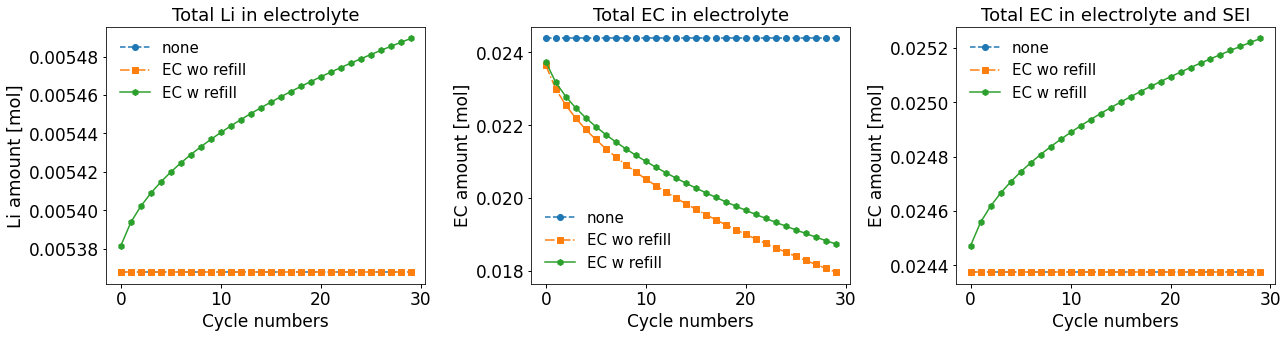

In [16]:
fs=17;Num_subplot = 3;
LS=['--','-.','-']; MA = ['o', 's', 'h',] 
fig, axs = plt.subplots(1,Num_subplot, figsize=(18,4.8),tight_layout=True)
for model,my_dict,ls,ma,cycle_no in zip(Models,my_dict_all,LS,MA,cycle_no_all):
    axs[0].plot(
        cycle_no, 
        my_dict["CDend Total lithium in electrolyte [mol]"],marker = ma, 
        linestyle=ls,
        label=model.options["solvent diffusion"] )
    axs[1].plot(
        cycle_no, 
        my_dict["CDend Total EC in electrolyte [mol]"] ,marker = ma, 
        linestyle=ls,
        label=model.options["solvent diffusion"] )
    axs[2].plot(
        cycle_no, 
        my_dict["CDend Total EC in electrolyte and SEI [mol]"] ,marker = ma, 
        linestyle=ls,
        label=model.options["solvent diffusion"] )
for i in range(0,Num_subplot):
    axs[i].set_xlabel("Cycle numbers",   fontdict={'family':'DejaVu Sans','size':fs})
    axs[i].set_ylabel("EC amount [mol]",   fontdict={'family':'DejaVu Sans','size':fs})
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)
   
axs[0].set_title("Total Li in electrolyte",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[1].set_title("Total EC in electrolyte",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[2].set_title("Total EC in electrolyte and SEI",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[0].set_ylabel("Li amount [mol]",   fontdict={'family':'DejaVu Sans','size':fs+1})

Text(0.5, 1.0, 'Capacity loss to SEI')

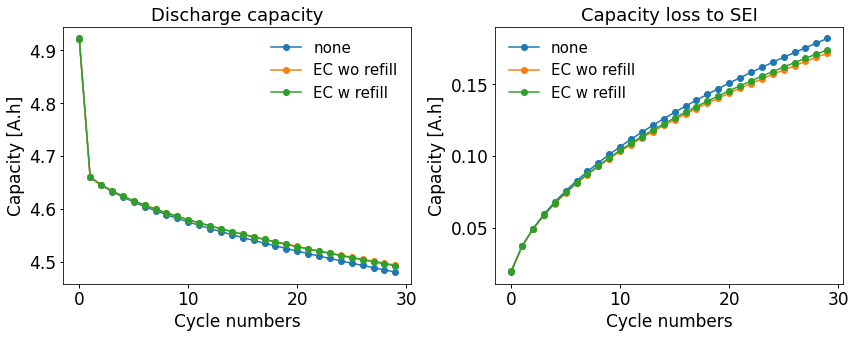

In [17]:
fs=17;Num_subplot = 2;
fig, axs = plt.subplots(1,Num_subplot, figsize=(12,4.8),tight_layout=True)
for model,my_dict,cycle_no in zip(Models,my_dict_all,cycle_no_all):
    axs[0].plot(
        cycle_no, 
        my_dict["Discharge capacity [A.h]"],'-o', 
        label=model.options["solvent diffusion"] )
    axs[1].plot(
        cycle_no, 
        my_dict["CDend Loss of capacity to SEI [A.h]"] ,'-o', 
        label=model.options["solvent diffusion"] )
for i in range(0,Num_subplot):
    axs[i].set_xlabel("Cycle numbers",   fontdict={'family':'DejaVu Sans','size':fs})
    axs[i].set_ylabel("Capacity [A.h]",   fontdict={'family':'DejaVu Sans','size':fs})
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)
    axs[i].set_title("Discharge capacity",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[1].set_title("Capacity loss to SEI",   fontdict={'family':'DejaVu Sans','size':fs+1})

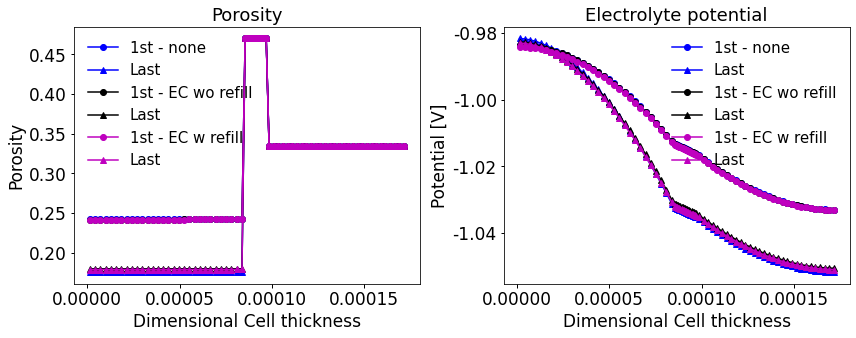

In [18]:
Num_subplot = 2;str_color = ['b', 'k', 'm']
fig, axs = plt.subplots(1,Num_subplot, figsize=(12,4.8),tight_layout=True)
for model,my_dict,co,cycle_no in zip(Models,my_dict_all,str_color,cycle_no_all):
    axs[0].plot(my_dict["x [m]"], my_dict["CDend Porosity"][0],'-o',color=co,label="1st - " + model.options["solvent diffusion"])
    axs[0].plot(my_dict["x [m]"], my_dict["CDend Porosity"][-1],'-^',color=co,label="Last")
    axs[1].plot(my_dict["x [m]"], my_dict["CDend Electrolyte potential [V]"][0],'-o',color=co,label="1st - " + model.options["solvent diffusion"] )
    axs[1].plot(my_dict["x [m]"], my_dict["CDend Electrolyte potential [V]"][-1],'-^',color=co,label="Last" )
axs[0].set_title("Porosity",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[1].set_title("Electrolyte potential",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[0].set_ylabel("Porosity",   fontdict={'family':'DejaVu Sans','size':fs})
axs[1].set_ylabel("Potential [V]",   fontdict={'family':'DejaVu Sans','size':fs})
for i in range(0,2):
    axs[i].set_xlabel("Dimensional Cell thickness",   fontdict={'family':'DejaVu Sans','size':fs})
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)    

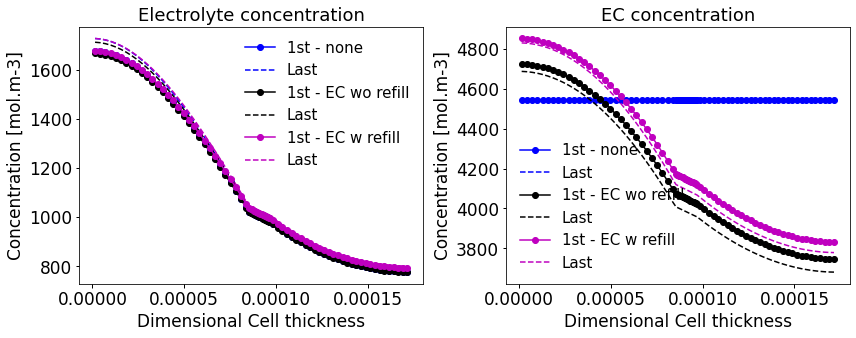

In [19]:
Num_subplot = 2;str_color = ['b', 'k', 'm']
n1=11; n2 = 12
fig, axs = plt.subplots(1,Num_subplot, figsize=(12,4.8),tight_layout=True)
for model,my_dict,co,cycle_no in zip(Models,my_dict_all,str_color,cycle_no_all):
    axs[0].plot(my_dict["x [m]"], my_dict["CDend Electrolyte concentration [mol.m-3]"][10],'-o',color=co,label="1st - " + model.options["solvent diffusion"])
    axs[0].plot(my_dict["x [m]"], my_dict["CDend Electrolyte concentration [mol.m-3]"][13],'--',color=co,label="Last")
    axs[1].plot(my_dict["x [m]"], my_dict["CDend EC concentration [mol.m-3]"][10],'-o',color=co,label="1st - " + model.options["solvent diffusion"] )
    axs[1].plot(my_dict["x [m]"], my_dict["CDend EC concentration [mol.m-3]"][13],'--',color=co,label="Last" )
axs[0].set_title("Electrolyte concentration",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[1].set_title("EC concentration",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[0].set_ylabel("Concentration [mol.m-3]",   fontdict={'family':'DejaVu Sans','size':fs})
axs[1].set_ylabel("Concentration [mol.m-3]",   fontdict={'family':'DejaVu Sans','size':fs})
for i in range(0,2):
    axs[i].set_xlabel("Dimensional Cell thickness",   fontdict={'family':'DejaVu Sans','size':fs})
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)    

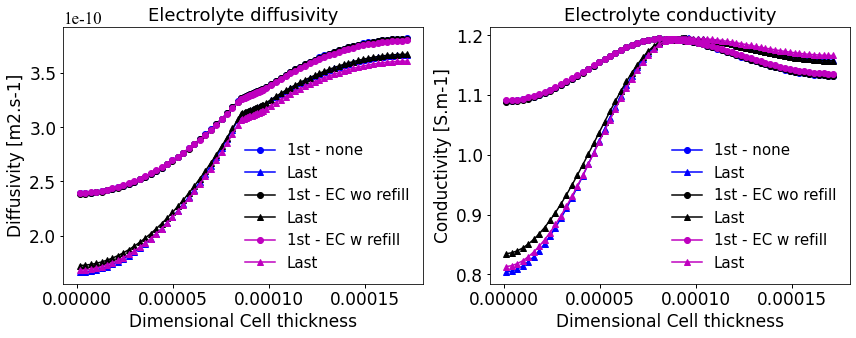

In [22]:
Num_subplot = 2;str_color = ['b', 'k', 'm']
fig, axs = plt.subplots(1,Num_subplot, figsize=(12,4.8),tight_layout=True)
for model,my_dict,co,cycle_no in zip(Models,my_dict_all,str_color,cycle_no_all):
    axs[0].plot(my_dict["x [m]"], my_dict["CDend Electrolyte diffusivity [m2.s-1]"][0],'-o',color=co,label="1st - " + model.options["solvent diffusion"])
    axs[0].plot(my_dict["x [m]"], my_dict["CDend Electrolyte diffusivity [m2.s-1]"][-1],'-^',color=co,label="Last")
    axs[1].plot(my_dict["x [m]"], my_dict["CDend Electrolyte conductivity [S.m-1]"][0],'-o',color=co,label="1st - " + model.options["solvent diffusion"] )
    axs[1].plot(my_dict["x [m]"], my_dict["CDend Electrolyte conductivity [S.m-1]"][-1],'-^',color=co,label="Last" )
axs[0].set_title("Electrolyte diffusivity",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[1].set_title("Electrolyte conductivity",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[0].set_ylabel("Diffusivity [m2.s-1]",   fontdict={'family':'DejaVu Sans','size':fs})
axs[1].set_ylabel("Conductivity [S.m-1]",   fontdict={'family':'DejaVu Sans','size':fs})
for i in range(0,2):
    axs[i].set_xlabel("Dimensional Cell thickness",   fontdict={'family':'DejaVu Sans','size':fs})
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


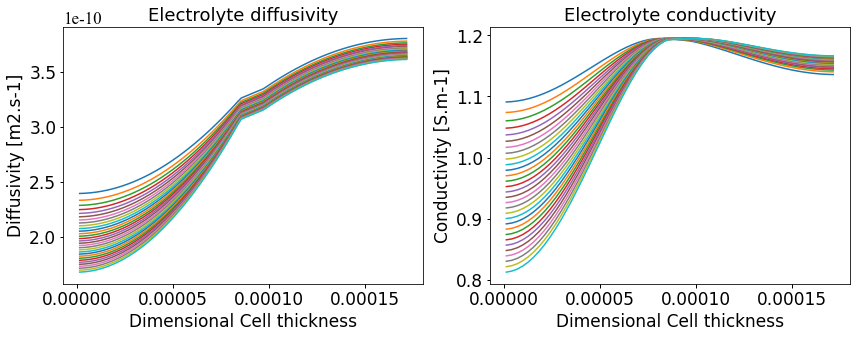

In [21]:

Num_subplot = 2;str_color = ['b', 'k', 'm']
fig, axs = plt.subplots(1,Num_subplot, figsize=(12,4.8),tight_layout=True)
diff_all = my_dict_all[-1]["CDend Electrolyte diffusivity [m2.s-1]"];
sigm_all = my_dict_all[-1]["CDend Electrolyte conductivity [S.m-1]"];
for diff,sigm in zip(diff_all,sigm_all):
    axs[0].plot(my_dict_all[-1]["x [m]"], diff,'-')
    axs[1].plot(my_dict_all[-1]["x [m]"], sigm,'-')
axs[0].set_title("Electrolyte diffusivity",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[1].set_title("Electrolyte conductivity",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[0].set_ylabel("Diffusivity [m2.s-1]",   fontdict={'family':'DejaVu Sans','size':fs})
axs[1].set_ylabel("Conductivity [S.m-1]",   fontdict={'family':'DejaVu Sans','size':fs})
for i in range(0,2):
    axs[i].set_xlabel("Dimensional Cell thickness",   fontdict={'family':'DejaVu Sans','size':fs})
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


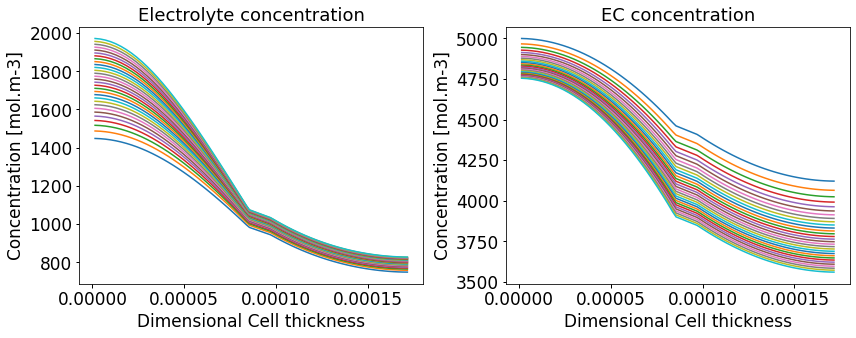

In [35]:

Num_subplot = 2;str_color = ['b', 'k', 'm']
fig, axs = plt.subplots(1,Num_subplot, figsize=(12,4.8),tight_layout=True)
c_e_all = my_dict_all[-1]["CDend Electrolyte concentration [mol.m-3]"];
c_ec_all = my_dict_all[-1]["CDend EC concentration [mol.m-3]"];
for c_e,c_ec in zip(c_e_all,c_ec_all):
    axs[0].plot(my_dict_all[-1]["x [m]"], c_e,'-')
    axs[1].plot(my_dict_all[-1]["x [m]"], c_ec,'-')
axs[0].set_title("Electrolyte concentration",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[1].set_title("EC concentration",   fontdict={'family':'DejaVu Sans','size':fs+1})
axs[0].set_ylabel("Concentration [mol.m-3]",   fontdict={'family':'DejaVu Sans','size':fs})
axs[1].set_ylabel("Concentration [mol.m-3]",   fontdict={'family':'DejaVu Sans','size':fs})
for i in range(0,2):
    axs[i].set_xlabel("Dimensional Cell thickness",   fontdict={'family':'DejaVu Sans','size':fs})
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
    axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)    